# Convolutional Neural Networks

In this notebook, we will cover training a simple convolutional neural network on the MNIST dataset, visualizing tuning of model neurons, computing representational similarity analysis (RSA) for different model layers

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

## MNIST Dataset

We will use the classical MNIST dataset because it allows rapid training on CPUs.

In [2]:
# Download MNIST dataset
path = Path('./')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
     ])
trainset = datasets.MNIST(path, train=True, download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = datasets.MNIST(path, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

Shape of images from one batch :  torch.Size([16, 1, 28, 28])
Shape of labels from one batch :  torch.Size([16])


Text(0.5, 1.0, 'Label 1')

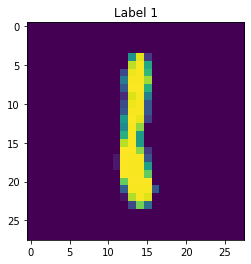

In [3]:
# Visualize an image from the dataset
for i, data in enumerate(train_loader):
    images, labels = data
    break
print('Shape of images from one batch : ', images.shape)
print('Shape of labels from one batch : ', labels.shape)

plt.imshow(images[0, 0])
plt.title('Label {}'.format(labels[0]))

## Define a convolutional neural network

In [153]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)  # 7*7 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Set whether to readout activation
        self.readout = False

    def forward(self, x):
        # Max pooling over a (2, 2) window
        l1 = F.max_pool2d(F.relu(self.conv1(x)), 2)
        l2 = F.max_pool2d(F.relu(self.conv2(l1)), 2)
        l2_flat = torch.flatten(l2, start_dim=1)  # flatten tensor, while keeping batch dimension
        l3 = F.relu(self.fc1(l2_flat))
        l4 = F.relu(self.fc2(l3))
        y = self.fc3(l4)
        
        if self.readout:
            return {'l1': l1, 'l2': l2, 'l3': l3, 'l4': l4, 'y': y}
        else:
            return y

## Training the network

The following code trains the above network on MNIST until it reaches 95% accuracy. It should take only ~500-1000 training steps.

In [155]:
import torch.optim as optim

# Instantiate the network and print information
net = Net()
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train for only one epoch
running_loss = 0
running_acc = 0
for i, data in enumerate(train_loader):
    image, label = data

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()    # Does the update

    # prediction
    prediction = torch.argmax(output, axis=-1)
    acc = torch.mean((label == prediction).float())

    running_loss += loss.item()
    running_acc += acc
    if i % 100 == 99:
        running_loss /= 100
        running_acc /= 100
        print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(
            i+1, running_loss, running_acc))
        if running_acc > 0.95:
            break
        running_loss, running_acc = 0, 0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Step 100, Loss 1.4195, Acc 0.526
Step 200, Loss 0.4941, Acc 0.838
Step 300, Loss 0.3259, Acc 0.906
Step 400, Loss 0.2316, Acc 0.927
Step 500, Loss 0.2036, Acc 0.932
Step 600, Loss 0.2074, Acc 0.933
Step 700, Loss 0.1975, Acc 0.936
Step 800, Loss 0.1601, Acc 0.954


## Compute representation similarity

We will first compute the neural responses to a batch of images

In [156]:
for i, data in enumerate(test_loader):
    images, labels = data
    break

# Readout network activity
net.readout = True
activity = net(images)

n_images = len(labels)

ind = np.argsort(labels.numpy())
images = images.detach().numpy()[ind]
labels = labels.numpy()[ind]

similarity = dict()
for key, val in activity.items():
    new_val = val.detach().numpy()[ind]
    activity[key] = new_val
    new_val = new_val.reshape(n_images, -1)
    similarity[key] = np.corrcoef(new_val)

Here we plot the representational dissimilarity matrix for neural responses of different layers

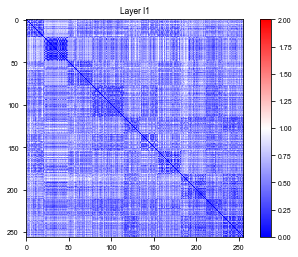

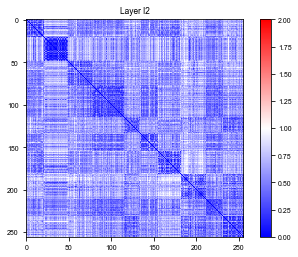

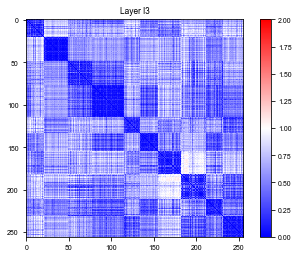

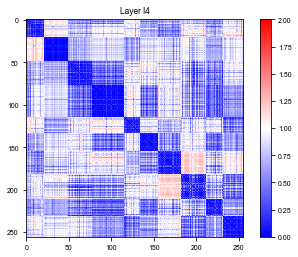

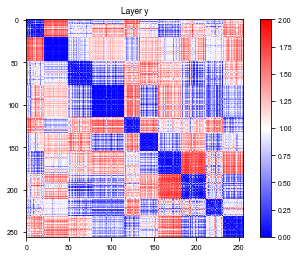

In [157]:
for layer, sim in similarity.items():
    plt.figure()
    plt.imshow(1 - sim, vmin=0, vmax=2, cmap='bwr')
    plt.colorbar()
    plt.title('Layer ' + layer)

## Search for preferred stimulus for a given neuron

We will optimize images (not weights) such as the activity of a chosen neuron is maximized

In [12]:
# Freeze for parameters in the network
for param in net.parameters():
    param.requires_grad = False
    

# Here syn_image is the variable to be optimized
# Initialized randomly for search in parallel
batch_size = 64
image_size = [batch_size] + list(images.shape[1:])
syn_image_init = np.random.rand(*image_size)
syn_image = torch.tensor(syn_image_init, requires_grad=True, dtype=torch.float32)

# Use Adam optimizer
optimizer = optim.Adam([syn_image], lr=0.01)

running_loss = 0
for i in range(1000):
    optimizer.zero_grad()   # zero the gradient buffers
    syn_image.data.clamp_(min=0.0, max=1.0)
    syn_image_transform = (syn_image - 0.1307) / 0.3081
    act = net(syn_image_transform)
    
    # Pick a neuron, and minimize its negative activity
    neuron = act['l4'][:, 2]
    if i == 0:
        neuron_init = neuron.detach().numpy()

    loss = -torch.mean(torch.square(neuron))
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
        running_loss /= 100
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

neuron = neuron.detach().numpy()
syn_image = syn_image.detach().numpy()

Step 100, Loss -716.7682
Step 200, Loss -1619.6920
Step 300, Loss -1819.8968
Step 400, Loss -1897.0763
Step 500, Loss -1940.6205
Step 600, Loss -1961.1659
Step 700, Loss -1979.3842
Step 800, Loss -2000.3697
Step 900, Loss -2011.0364
Step 1000, Loss -2020.5291


Plot the neural activity driven by a batch of images before and after the optimization process. After optimization, many images can drive the unit strongly.

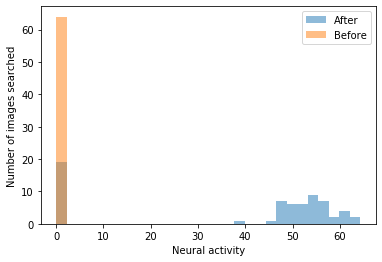

In [13]:
bins = np.linspace(0, np.max(neuron), 30)
plt.figure()
plt.hist(neuron, bins, label='After', alpha=0.5)
plt.hist(neuron_init, bins, label='Before', alpha=0.5)
plt.xlabel('Neural activity')
plt.ylabel('Number of images searched')
plt.legend()

Visualize the image that most strongly activates the chosen unit, before and after optimization.

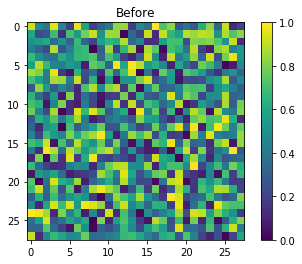

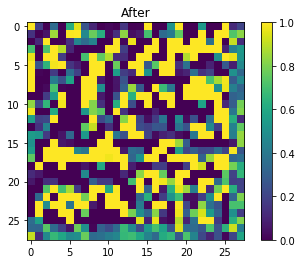

In [14]:
ind = np.argsort(neuron)
plt.figure()
plt.title('Before')
plt.imshow(syn_image_init[ind[-1], 0], vmin=0, vmax=1)
plt.colorbar()

plt.figure()
plt.title('After')
plt.imshow(syn_image[ind[-1], 0], vmin=0, vmax=1)
plt.colorbar()

# Supplementary materials

Code for making publication quality figures

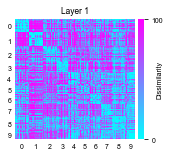

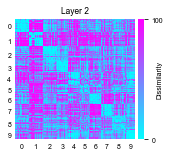

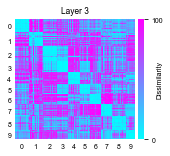

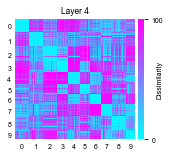

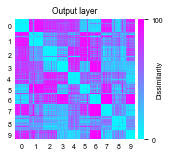

In [77]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from pathlib import Path

mpl.rcParams['font.size'] = 7
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'arial'

ticks = [np.mean(np.where(labels == l)) for l in range(10)]

for layer, sim in similarity.items():
    dissim = 1 - sim
    # Convert to percentile
    dissim_flat = dissim.flatten()
    dissim_flat_new = np.zeros(len(dissim_flat))
    for i, ind in enumerate(np.argsort(dissim_flat)):
        dissim_flat_new[ind] = i
    
    dissim_flat = dissim_flat_new / len(dissim_flat) * 100
    dissim = dissim_flat.reshape(dissim.shape)
    
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([.2, .2, .6, .6])
    im = ax.imshow(dissim, cmap='cool', vmin=0, vmax=100, aspect=1,
                   extent=(-0.5, len(labels)-0.5, len(labels)-0.5, -0.5),
                   interpolation='nearest'
                  )
    if layer != 'y':
        title = 'Layer ' + layer[-1]
    else:
        title = 'Output layer'
    plt.title(title)
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)
        
    ax.set_xticks(ticks)
    ax.set_xticklabels([str(i) for i in range(10)])
    ax.set_yticks([-0.5] + ticks + [len(labels)-0.5])
    ax.set_yticklabels([''] + [str(i) for i in range(10)] + [''])
    ax.tick_params(length=0)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, ticks=[0, 100])
    cb.set_label('Dissimilarity', labelpad=-7)
    cb.outline.set_linewidth(0)
    
    fname = Path('figures/RSA_' + layer)
    fig.savefig(fname.with_suffix('.pdf'), transparent=True)
    fig.savefig(fname.with_suffix('.png'), dpi=300)

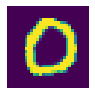

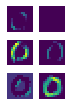

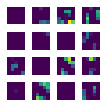

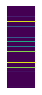

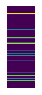

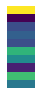

In [130]:
# Plot network activity
i_image = 0

fig = plt.figure(figsize=(1.5, 1.5))
plt.imshow(images[i_image, 0])
fname = Path('figures/sample_cnn_image')
plt.axis('off')
fig.savefig(fname.with_suffix('.pdf'), transparent=True)
fig.savefig(fname.with_suffix('.png'), dpi=300)

layers = ['l1', 'l2', 'l3', 'l4', 'y']

for layer in layers:
    act = activity[layer]
    act = act[i_image]
    if len(act.shape) == 3:
        n_channels = act.shape[0]
        if n_channels == 6:
            n_x, n_y = 2, 3
        elif n_channels == 16:
            n_x, n_y = 4, 4
        else:
            n_x, n_y = n_channels, 1
        vmax = np.max(act)
        fig, axs = plt.subplots(n_y, n_x, figsize=(1.5/n_y*n_x, 1.5))
        for i_channel in range(n_channels):
            ax = axs[np.mod(i_channel, n_y), i_channel//n_y]
            ax.imshow(act[i_channel], vmin=0, vmax=vmax)
            ax.set_axis_off()
        plt.tight_layout()
    elif len(act.shape) == 1:
        fig = plt.figure(figsize=(0.5, 1.5))
        plt.imshow(act[:, np.newaxis], aspect='auto')
        plt.axis('off')
        
    fname = Path('figures/sample_cnn_activity_' + layer)
    fig.savefig(fname.with_suffix('.pdf'), transparent=True)
    fig.savefig(fname.with_suffix('.png'), dpi=300)

In [181]:
def get_syn_image(layer):
    # Here syn_image is the variable to be optimized
    # Initialized randomly for search in parallel
    batch_size = 64
    image_size = [batch_size] + list(images.shape[1:])
    syn_image_init = np.random.rand(*image_size)
    syn_image = torch.tensor(syn_image_init, requires_grad=True, dtype=torch.float32)

    # Use Adam optimizer
    optimizer = optim.Adam([syn_image], lr=0.01)

    running_loss = 0
    running_loss_reg = 0
    for i in range(1000):
        optimizer.zero_grad()   # zero the gradient buffers
        syn_image.data.clamp_(min=0.0, max=1.0)
        syn_image_transform = (syn_image - 0.1307) / 0.3081
        activity = net(syn_image_transform)

        # Pick a neuron, and minimize its negative activity
        neuron = activity[layer]

        # Choose a neuron that is already most activated
        if i == 0:
            neuron_avg = np.mean(neuron.detach().numpy(), axis=0)
            ind = np.argsort(neuron_avg.flatten())[-1]
            print('Chosen unit', ind)

        neuron = neuron.view(batch_size, -1)[:, ind]
        if i == 0:
            neuron_init = neuron.detach().numpy()

        loss = -torch.mean(torch.square(neuron))
        loss_reg = torch.mean(torch.square(syn_image_transform)) * 100
        loss += loss_reg
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_reg += loss_reg.item()
        if i % 100 == 99:
            running_loss /= 100
            running_loss_reg /= 100
            print('Step {}, Loss {:0.4f} Loss Regularization {:0.4f}'.format(
                i+1, running_loss, running_loss_reg))
            running_loss, running_loss_reg = 0, 0

    neuron = neuron.detach().numpy()
    syn_image = syn_image.detach().numpy()
    return syn_image, syn_image_init, neuron

layers = ['l1', 'l2', 'l3', 'l4', 'y']
results = dict()
for layer in layers:
    print('Layer ', layer)
    syn_image, syn_image_init, neuron = get_syn_image(layer)
    results[layer] = {'syn_image': syn_image,
                      'syn_image_init': syn_image_init,
                      'neuron': neuron}

Layer  l1
Chosen unit 695
Step 100, Loss 40.3576 Loss Regularization 60.7293
Step 200, Loss -18.4666 Loss Regularization 7.0453
Step 300, Loss -18.6952 Loss Regularization 6.8230
Step 400, Loss -18.6953 Loss Regularization 6.8229
Step 500, Loss -18.6953 Loss Regularization 6.8229
Step 600, Loss -18.6953 Loss Regularization 6.8229
Step 700, Loss -18.6953 Loss Regularization 6.8229
Step 800, Loss -18.6953 Loss Regularization 6.8229
Step 900, Loss -18.6953 Loss Regularization 6.8229
Step 1000, Loss -18.6953 Loss Regularization 6.8229
Layer  l2
Chosen unit 151
Step 100, Loss 12.1516 Loss Regularization 69.1384
Step 200, Loss -59.3885 Loss Regularization 18.2448
Step 300, Loss -60.0104 Loss Regularization 18.0552
Step 400, Loss -60.0320 Loss Regularization 18.0426
Step 500, Loss -60.0372 Loss Regularization 18.0319
Step 600, Loss -60.0376 Loss Regularization 18.0301
Step 700, Loss -60.0376 Loss Regularization 18.0301
Step 800, Loss -60.0376 Loss Regularization 18.0300
Step 900, Loss -60.037

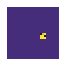

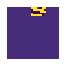

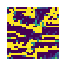

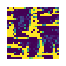

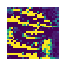

In [187]:
for layer in layers:
    res = results[layer]
    ind = np.argsort(res['neuron'])

    fig = plt.figure(figsize=(0.8, 0.8))
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
    ax.imshow(res['syn_image'][ind[-1], 0], vmin=0, vmax=1)
    plt.axis('off')

    fname = Path('figures/cnn_tuning_' + layer)
    fig.savefig(fname.with_suffix('.pdf'), transparent=True)
    fig.savefig(fname.with_suffix('.png'), dpi=300)